<a href="https://colab.research.google.com/github/kerfriden/SurrOptim/blob/main/demo_surroptim.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [31]:
try:
    import surroptim
except:
    #!pip uninstall -y surroptim
    !pip install -q "git+https://github.com/kerfriden/SurrOptim@main" --force-reinstall

=== Test 1: Sparse Grid Sampling ===
Building your FEA sampler...
distribution type for dimension 0: uniform
bounds of distribution for dimension 0: [-2, 2.0]
distribution type for dimension 1: uniform
bounds of distribution for dimension 1: [-2.0, 2.0]
... done building
Start computing 65 samples in parametric dimension 2 using SG
... done sampling


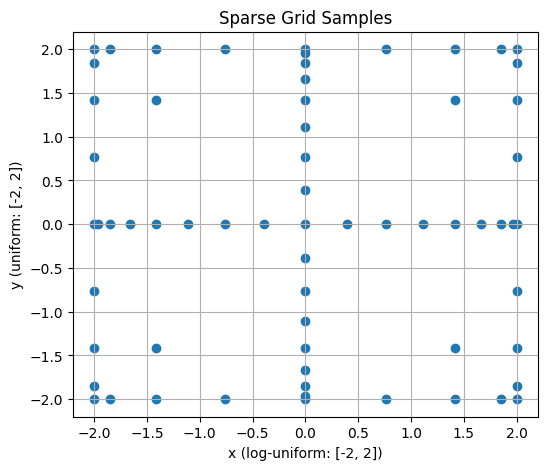


=== Test 1b: Sparse Grid with Log-Uniform ===
Building your FEA sampler...
distribution type for dimension 0: log_uniform
bounds of distribution for dimension 0: [np.float64(0.1353352832366127), np.float64(7.38905609893065)]
distribution type for dimension 1: uniform
bounds of distribution for dimension 1: [-2.0, 2.0]
... done building
Start computing 65 samples in parametric dimension 2 using SG
... done sampling


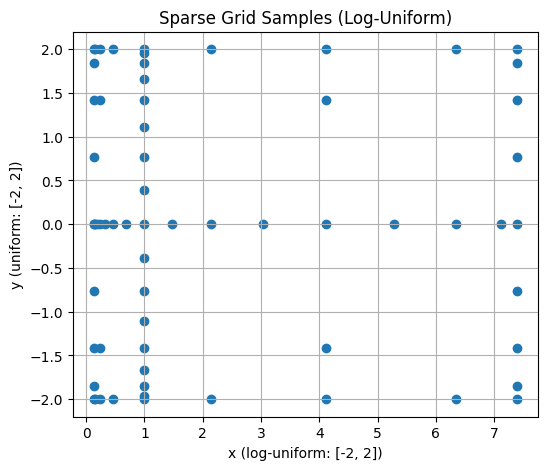

In [26]:
"""Demo script: SurrOptim sampling and metamodeling."""

import numpy as np
import matplotlib.pyplot as plt

from surroptim.sampler import sampler_cls
from surroptim.polynomial_meta_models import polynomial_lasso_regressor

# ============================================================================
# 1. Simple sparse grid sampling
# ============================================================================
print("=== Test 1: Sparse Grid Sampling ===")
sampler_sg = sampler_cls(
    distributions=["uniform", "uniform"],
    bounds=[[-2, 2.], [-2., 2.]],
    DOE_type='SG'
)

sampler_sg.sample(N=5)

plt.figure(figsize=(6, 5))
plt.scatter(sampler_sg.X[:, 0], sampler_sg.X[:, 1])
plt.xlabel("x (log-uniform: [-2, 2])")
plt.ylabel("y (uniform: [-2, 2])")
plt.grid()
plt.title("Sparse Grid Samples")
plt.show()

# ============================================================================
# 1b. Sparse grid with log-uniform (requires positive bounds)
# ============================================================================
print("\n=== Test 1b: Sparse Grid with Log-Uniform ===")
sampler_sg_log = sampler_cls(
    distributions=["log_uniform", "uniform"],
    bounds=[[np.exp(-2), np.exp(2.)], [-2., 2.]],
    DOE_type='SG'
)

sampler_sg_log.sample(N=5)

plt.figure(figsize=(6, 5))
plt.scatter(sampler_sg_log.X[:, 0], sampler_sg_log.X[:, 1])
plt.xlabel("x (log-uniform: [-2, 2])")
plt.ylabel("y (uniform: [-2, 2])")
plt.grid()
plt.title("Sparse Grid Samples (Log-Uniform)")
plt.show()


=== Test 2: Incremental Sampling with Sigmoid QoI ===


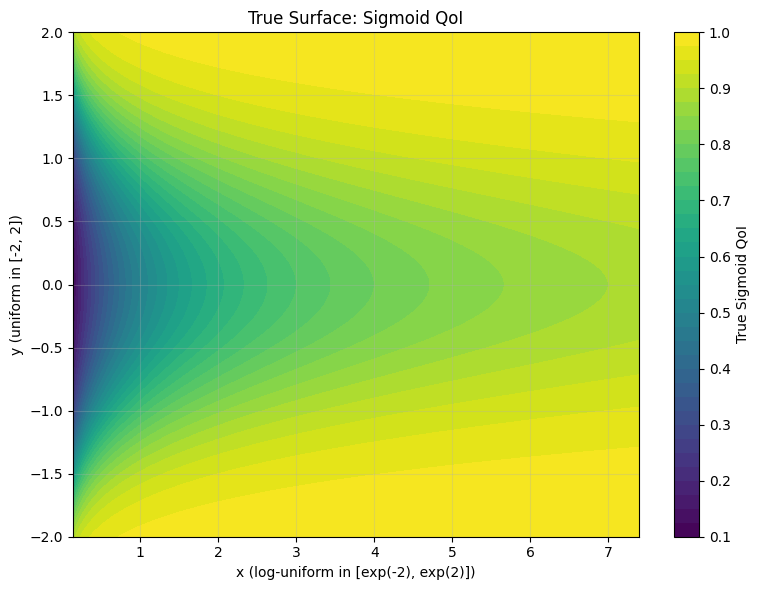

In [38]:
# ============================================================================
# 2. Incremental sampling with QoI evaluation and active_keys
# ============================================================================
print("\n=== Test 2: Incremental Sampling with Sigmoid QoI ===")

all_parameters = {"x": 0, "y": 1, "unused": 0}

def sigmoid_qoi(active_param) -> np.ndarray:
    """QoI: [sum, sigmoid]"""
    for key, value in active_param.items():
        all_parameters[key] = value
    x = all_parameters["x"]
    y = all_parameters["y"]
    s = np.log(x) + y**2
    sig = 1.0 / (1.0 + np.exp(-s))
    return np.vstack([s, sig]).T

# --- True surface using the existing QoI (no points) ---
fig, ax = plt.subplots(figsize=(8, 6))

nx, ny = 200, 200
xg = np.linspace(np.exp(-2), np.exp(2), nx)
yg = np.linspace(-2.0, 2.0, ny)
Xg, Yg = np.meshgrid(xg, yg)

# Evaluate QoI on the grid by calling sigmoid_qoi for each (x, y)
XX = Xg.ravel()
YY = Yg.ravel()

qoi_vals = np.array([sigmoid_qoi({'x': x, 'y': y})[0] for x, y in zip(XX, YY)])
# qoi_vals shape: (nx*ny, 2) with columns [s, sigmoid]

Sig_true = qoi_vals[:, 1].reshape(Yg.shape)   # 2nd column = sigmoid

cf = ax.contourf(Xg, Yg, Sig_true, levels=40, cmap="viridis")
plt.colorbar(cf, ax=ax, label="True Sigmoid QoI")

ax.set_xlabel("x (log-uniform in [exp(-2), exp(2)])")
ax.set_ylabel("y (uniform in [-2, 2])")
ax.set_title("True Surface: Sigmoid QoI")
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

Building your FEA sampler...
parameter dimension 0: x
distribution type for dimension 0: log_uniform
bounds of distribution for dimension 0: [np.float64(0.1353352832366127), np.float64(7.38905609893065)]
parameter dimension 1: y
distribution type for dimension 1: uniform
bounds of distribution for dimension 1: [-2.0, 2.0]
n_out not provided -> calling FEA solver for automatic determination
QoIs at test point: [[0.  0.5]]
n_out: 2
... done building
Start computing 5 samples in parametric dimension 2 using QRS
... done sampling
First batch: 5 samples
Start computing 5 additional samples in parametric dimension 2 using QRS
... done sampling
After incremental: 10 total samples


/tmp/ipython-input-3983693571.py:26: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('+').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(X_before[:, 0], X_before[:, 1], c=cvals, cmap="viridis",


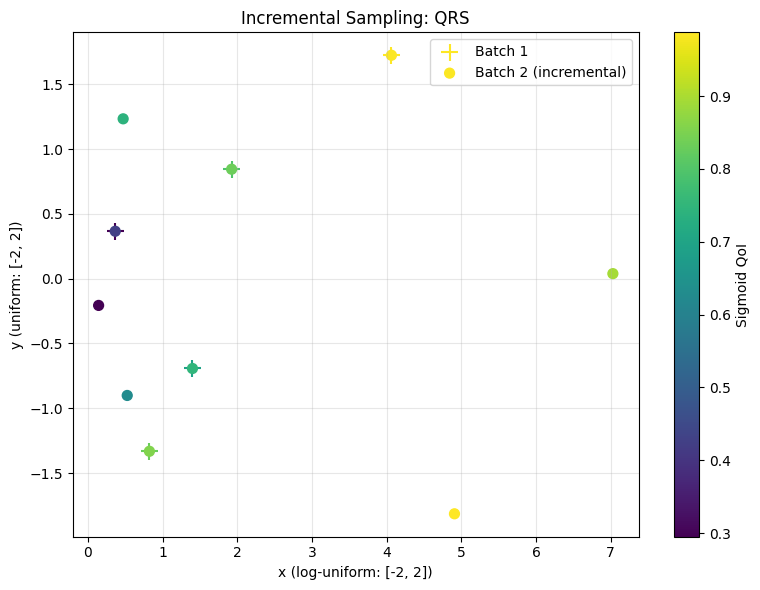

In [39]:
sampler = sampler_cls(
    distributions=["log_uniform", "uniform"],
    bounds=[[np.exp(-2), np.exp(2.)], [-2., 2.]],
    active_keys=['x', 'y'],
    compute_QoIs=sigmoid_qoi,
    DOE_type='QRS',
    seed=0
)

# First batch
sampler.sample(N=5)
X_before = sampler.X.copy()
Y_before = sampler.Y.copy()

print(f"First batch: {len(X_before)} samples")

# Incremental sampling
sampler.sample(N=5, as_additional_points=True)
print(f"After incremental: {len(sampler.X)} total samples")

# Plot
fig, ax = plt.subplots(figsize=(8, 6))

# First batch
cvals = Y_before[:,1]
ax.scatter(X_before[:, 0], X_before[:, 1], c=cvals, cmap="viridis",
          s=150, marker='+', label='Batch 1', edgecolors='black', linewidths=1.5)

# Incremental batch
cvals_new = sampler.Y[:,1]
ax.scatter(sampler.X[:, 0], sampler.X[:, 1],
          c=cvals_new, cmap="viridis", s=50, label='Batch 2 (incremental)')

ax.set_xlabel("x (log-uniform: [-2, 2])")
ax.set_ylabel("y (uniform: [-2, 2])")
ax.set_title("Incremental Sampling: QRS")
ax.grid(True, alpha=0.3)
ax.legend()
plt.colorbar(ax.collections[0], ax=ax, label='Sigmoid QoI')
plt.tight_layout()
plt.show()


=== Test 3: Polynomial Model + Grid Prediction ===
Lasso weights: 280 zero, 10 non-zero (zero fraction 0.966)
Model trained on 10 samples
Building your FEA sampler...
parameter dimension 0: x
distribution type for dimension 0: log_uniform
bounds of distribution for dimension 0: [np.float64(0.1353352832366127), np.float64(7.38905609893065)]
parameter dimension 1: y
distribution type for dimension 1: uniform
bounds of distribution for dimension 1: [-2.0, 2.0]
n_out not provided -> calling FEA solver for automatic determination
QoIs at test point: [[0.  0.5]]
n_out: 2
... done building
Start computing 30 samples in parametric dimension 2 using QRS
... done sampling


/usr/local/lib/python3.12/dist-packages/surroptim/polynomial_meta_models.py:86: RuntimeWarning: Lasso sparsity is outside 10%-90% range; consider tuning alpha.
  warnings.warn(


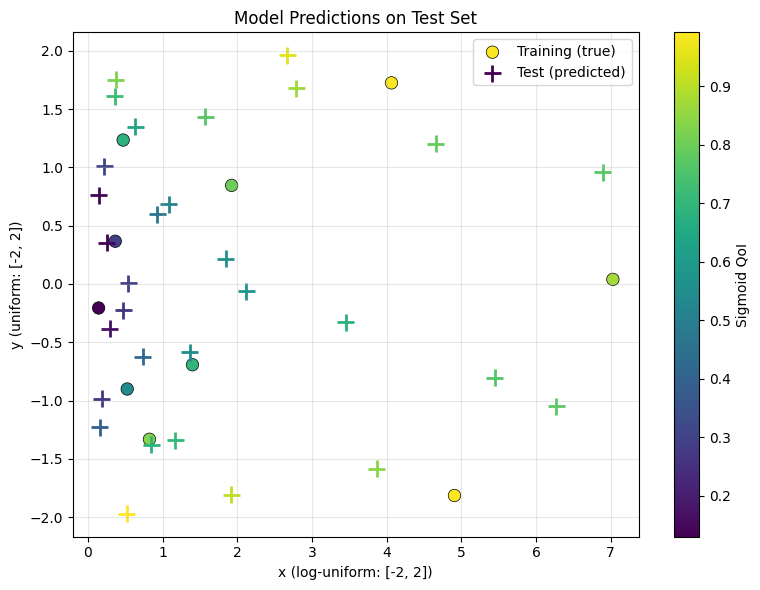

In [48]:
# ============================================================================
# 3. Train metamodel and predict on grid
# ============================================================================
print("\n=== Test 3: Polynomial Model + Grid Prediction ===")

model = polynomial_lasso_regressor(order=6, coeff_reg=1e-3, SG=True)
model.train(sampler.X_reference, sampler.Y)

print(f"Model trained on {len(sampler.X)} samples")

# Test set
sampler_test = sampler_cls(
    distributions=["log_uniform", "uniform"],
    bounds=[[np.exp(-2), np.exp(2.)], [-2., 2.]],
    active_keys=['x', 'y'],
    compute_QoIs=sigmoid_qoi,
    DOE_type='QRS',
    seed=1
)
sampler_test.sample(N=30)

preds = model.predict(sampler_test.X_reference)

# Visualize: training vs test predictions
fig, ax = plt.subplots(figsize=(8, 6))

# Training points (true QoI)
cvals_train = sampler.Y[:, 1]
sc_train = ax.scatter(sampler.X[:, 0], sampler.X[:, 1], c=cvals_train,
                      cmap="viridis", s=80, label='Training (true)',
                      edgecolors='black', linewidths=0.5)

# Test predictions
cvals_test = preds[:, 1]
ax.scatter(sampler_test.X[:, 0], sampler_test.X[:, 1], marker="+",
          c=cvals_test, cmap="viridis", s=150, label='Test (predicted)', linewidths=2)

ax.set_xlabel("x (log-uniform: [-2, 2])")
ax.set_ylabel("y (uniform: [-2, 2])")
ax.set_title("Model Predictions on Test Set")
ax.grid(True, alpha=0.3)
ax.legend()
plt.colorbar(sc_train, ax=ax, label='Sigmoid QoI')
plt.tight_layout()
plt.show()

In [49]:
from surroptim.util import r2_score

preds = model.predict(sampler.X_reference)
r2 = r2_score(sampler.Y[:,1], preds[:, 1])
print("r2 for training set :",r2)

preds = model.predict(sampler_test.X_reference)
r2 = r2_score(sampler_test.Y[:,1], preds[:, 1])
print("r2 for test set :",r2)

r2 for training set : 0.9925311550005445
r2 for test set : 0.9585541396042512



=== Test 4: Contour Grid Prediction ===


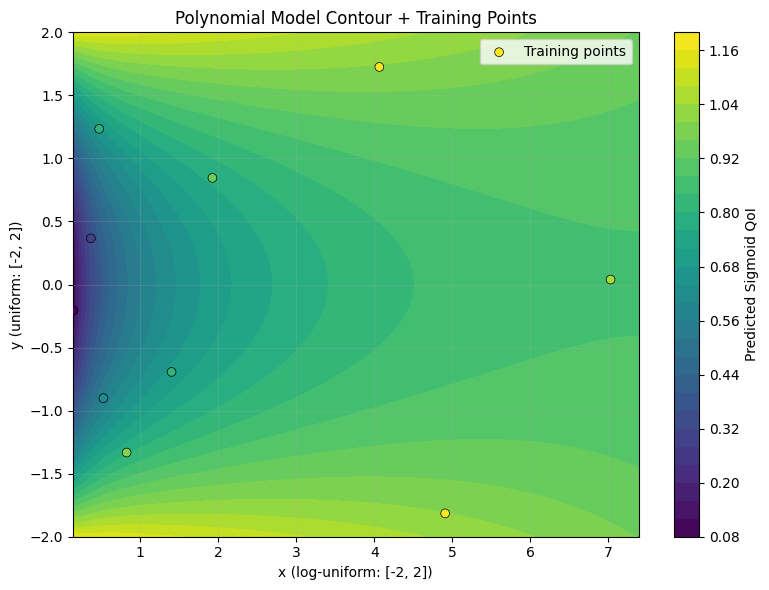


✓ Demo completed successfully!


In [50]:
# ============================================================================
# 4. Contour plot on grid
# ============================================================================
print("\n=== Test 4: Contour Grid Prediction ===")

# Physical space grid
xmin, xmax = -1, 1
ymin, ymax = -1, 1
ng = 100

xx = np.linspace(xmin, xmax, ng)
yy = np.linspace(ymin, ymax, ng)
Xg, Yg = np.meshgrid(xx, yy)

grid_ref = np.c_[Xg.ravel(), Yg.ravel()]  # (ng*ng, 2) in physical space

# Convert to reference space

# Predict on grid
pred_grid = model.predict(grid_ref)  # shape (ng*ng, n_out)
Z = pred_grid[:, 1].reshape(ng, ng)  # QoI[1]

Xg, Yg = np.meshgrid(xx, yy)

U = np.c_[Xg.ravel(), Yg.ravel()]
U_phys = sampler.reference2physical(U)  # Normalize grid for prediction
Xg_phys = U_phys[:, 0].reshape(Xg.shape)          # (ny, nx)
Yg_phys = U_phys[:, 1].reshape(Yg.shape)

# Plot
fig, ax = plt.subplots(figsize=(8, 6))
cf = ax.contourf(Xg_phys, Yg_phys, Z, levels=30, cmap="viridis")
cbar = plt.colorbar(cf, ax=ax, label="Predicted Sigmoid QoI")

# Overlay training points
ax.scatter(sampler.X[:, 0], sampler.X[:, 1],
           c=sampler.Y[:, 1], cmap="viridis",
           edgecolors="black", linewidths=0.5, s=40,
           label="Training points", zorder=5)

ax.set_xlabel("x (log-uniform: [-2, 2])")
ax.set_ylabel("y (uniform: [-2, 2])")
ax.set_title("Polynomial Model Contour + Training Points")
ax.legend()
ax.grid(True, alpha=0.2)
plt.tight_layout()
plt.show()

print("\n✓ Demo completed successfully!")